In [1]:
%matplotlib inline
import torch
import torchvision
import json
import cv2
import numpy as np
import os

from matplotlib import pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter 
from torchvision import transforms, utils
from torchsummary import summary

from Data_Loader import Pose_Dataset, my_collate, RandomFlip, RandomRotate, ToTensor
from model import VRUNet
from Modify_annotations import scale_annotations

In [2]:
# set parameters here before training

# fraction of validation dataset, default = 5%
val_fraction = 0.05 

# train, val batch size
train_batch_size = 4
val_batch_size = 4

# use multiple GPUs if available, default = True
multi_GPU = True

# number of epochs
num_epochs = 2

# annotations and image path
annotations_path = 'Data/annotations/vru_keypoints_val.json'
img_path = 'Data/images/val'

# don't modify this
scaled_annotations_path = annotations_path[:-5] + '_copy.json'

In [3]:
scale_annotations(annotations_path, scaled_annotations_path)

In [4]:
torch.cuda.empty_cache()

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
dataset = Pose_Dataset(annotations_path = scaled_annotations_path,
                      img_path = img_path,
                      transform = transforms.Compose([
                          RandomFlip(0.5),
                          RandomRotate(degree = 10),
                          ToTensor()
                      ]))

len_val_images = int(len(dataset)*val_fraction)
len_train_images = len(dataset) - len_val_images

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len_train_images, len_val_images]) 

train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn = my_collate)
val_dataloader = DataLoader(val_dataset, batch_size = val_batch_size, shuffle = False, collate_fn = my_collate)

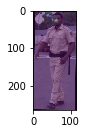

In [7]:
# visualize batch of images from dataloader
iterator = iter(train_dataloader)
images, target = next(iterator)

fig = plt.figure()
axes = []
for i in range(images.shape[0]):
    img = np.transpose(images[i].cpu(), (1,2,0))
    axes.append(fig.add_subplot(2, 4, i+1))
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.imshow(target[i][51].cpu(), alpha = 0.5)
plt.show()

In [8]:
model = VRUNet()
if torch.cuda.device_count() > 1 and multi_GPU:
    print("Using ",torch.cuda.device_count(), " GPUs for training!!")
    model = nn.DataParallel(model)

model.to(device)

VRUNet(
  (Backbone): BackBone(
    (bb1): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): Conv(
        (conv): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (2): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (3): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (bb2): Seque

In [9]:
# Setting up tensorboard
writer = SummaryWriter('runs/VRU_Net_experiment1')
dataiter = iter(train_dataloader)
images, targets = dataiter.next()
img_grid = torchvision.utils.make_grid(images)
writer.add_image('train_loader image batch', img_grid)

In [10]:
writer.add_graph(model, images)
writer.close()

C:\Users\Kartikaeya\Anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\Kartikaeya\Desktop\Internship\Pose_Estimation\Livewire\Pose_Estimation_LiveWire\model.py:210: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  for i in range(input_img.shape[0]):


In [11]:
#train the neural network finally
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_func = torch.nn.MSELoss(reduction = 'sum')

running_train_loss = 0
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, target in train_dataloader:
        i += 1
        if(images.shape[0] == 0):
            i -= 1
            continue
        optimizer.zero_grad()
        pred = model(images)
        loss = 25*loss_func(pred[:, 0:17], target[:, 0:17]) + 150*loss_func(pred[:, 17:34], target[:, 17:34]) + 500*loss_func(pred[:, 34:51], target[:, 34:51]) +  1000*loss_func(pred[:, 51:68], target[:, 51:68])
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
        # write train, val losses to tensorboard
        if i%500 == 999:
            writer.add_scalar('train_loss', running_train_loss/1000, epoch * len(train_dataloader) + i)

            model.eval()
            with torch.no_grad():
                valid_loss = sum(loss_func(model(img), trgt) for img, trgt in val_dataloader)
            writer.add_scalar('val_loss', valid_loss/len(val_dataloader),  epoch * len(train_dataloader) + i)
            model.train()
            running_train_loss = 0
torch.save(model.state_dict(), "trained_models/first_model.pth")
print("finished training!!")

finished training!!
